# Cluster analysis

In [790]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib.lines import Line2D

import seaborn as sns

import branca.colormap as cmp

from scipy.spatial import ConvexHull

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix

from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import cophenet, linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering

import folium
from folium.features import DivIcon
from shapely.geometry import shape
from branca.element import Template, MacroElement

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

### Get imput values

In [791]:
plt.style.use('ggplot')

# loading previously saved data: df_covid
df_covid = pd.read_csv("datasets/dataCOVID_all.csv")
df_covid = df_covid.loc[(df_covid['date'] <= '2020-12-31')]

In [792]:
# available days & dimension
dates = df_covid['date'].unique()
m = len(dates)

# regions (geographical order)
reg = df_covid['region'].unique()
n = len(reg)

# x-axis
t = np.arange(0, m)
mn = m * n

# replace odd cases (deaths < 0)
df_covid['deaths'] = np.where(df_covid['deaths'] < 0, 0, df_covid['deaths'])

# clustering on P-spline coefficients
ndx = np.floor(m / 5)
deg = 3
nbx = ndx + deg

LMX = np.full((m, n,), 0)
COEF = np.full((int(nbx), n,), 0)

### Load R and perform P-spline smoothing on dataset

In [793]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [794]:
%%R -i df_covid,n,m,nbx,ndx,t -o fit_i,COEF,LMX,LMX_hat
library(MortalitySmooth)

LMX <- LMX_hat <- matrix(0, m, n)
COEF <- matrix(0, nbx, n)
colnames(COEF) <- unique(df_covid$region)
for (i in 1:n) {
  data_i <- subset(df_covid, region == unique(df_covid$region)[i])
  fit_i <- Mort1Dsmooth(x = t,
                        y = data_i$deaths,
                        offset = log(data_i$population),
                        lambda = 10^3,
                        method = 3)
  COEF[, i] <- fit_i$coefficients
  LMX_hat[, i] <- fit_i$logmortality
  LMX[, i] <- log(data_i$deaths / data_i$population)
}

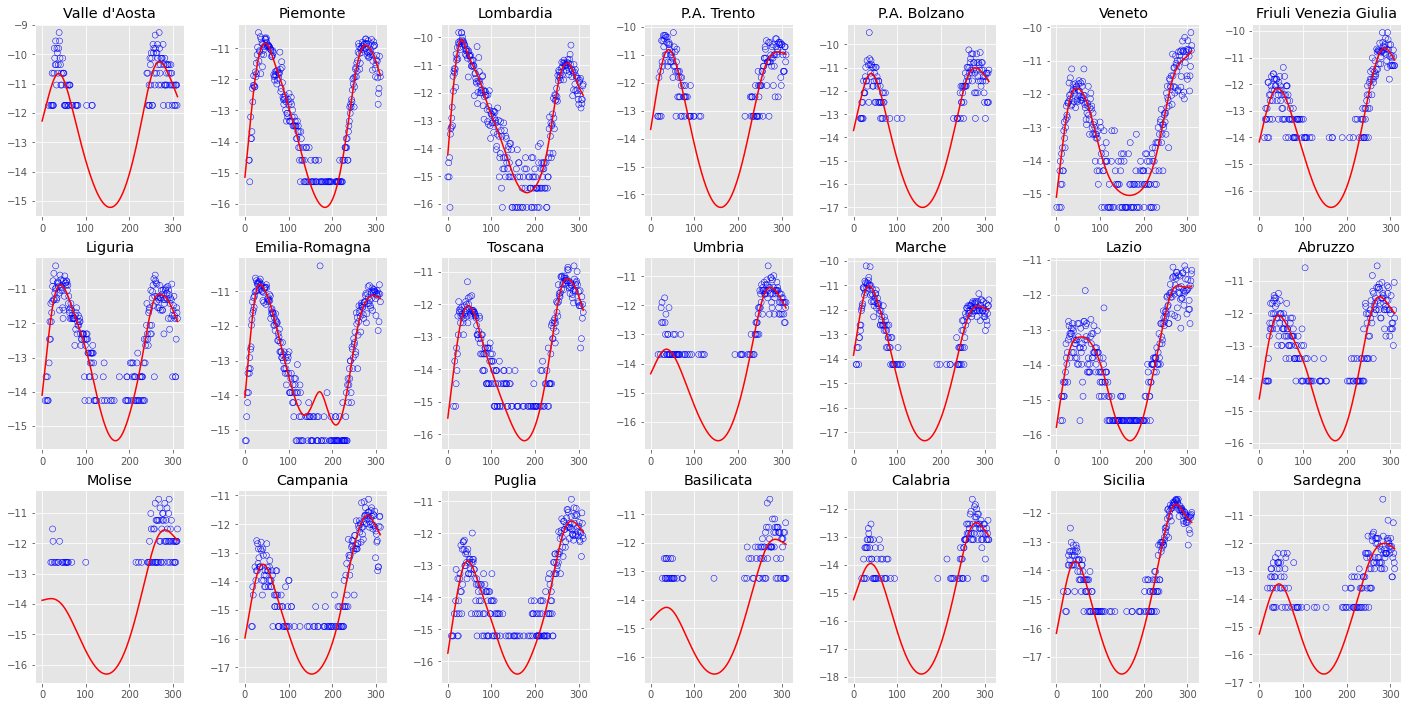

In [795]:
# plotting smooth curves

df_LMX = pd.DataFrame(LMX)
df_LMX_hat = pd.DataFrame(LMX_hat)

fig_row, fig_col = 3, 7
fig, axs = plt.subplots(fig_row, fig_col, figsize=(20, 10))
fig.tight_layout(pad=2.0)

r, c = -1, 0
for i in np.arange(0, n):
    if i % fig_col == 0:
        r += 1
        c = 0
    else: 
        c += 1
    
    axs[r, c].scatter(df_LMX[[i]].index.values, df_LMX[[i]], marker='o', facecolors='none', edgecolors='b')
    axs[r, c].plot(df_LMX_hat[[i]].index.values, df_LMX_hat[[i]], 'r')

    axs[r, c].set_title(reg[i])
    
plt.show()

### K-means clustering
Getting the scores for optimal number of clusters

In [797]:
# select data to cluster
dati = COEF.T

Perform k-means on 4 cluster

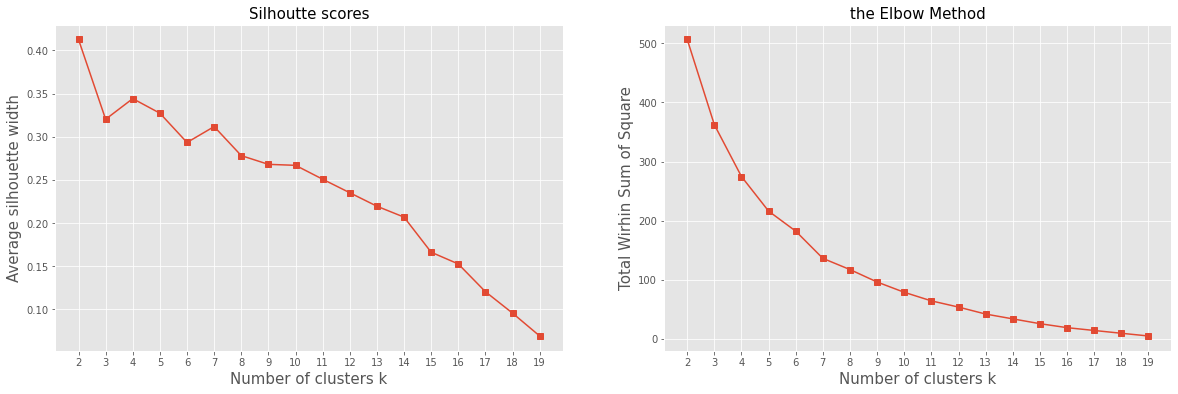

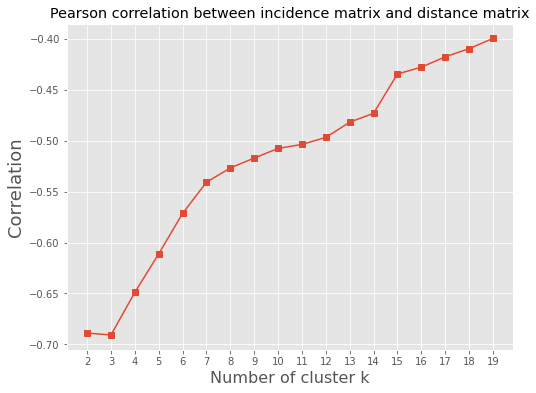

In [813]:
# number of clusters
nc = 4

silhoutteValutations = []; corrcoef = []; SSE = []

K = np.arange(2, 20)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=123)
    kmeans.fit(dati)
    silhoutteValutations.append(silhouette_score(dati, kmeans.labels_, metric='euclidean'))
    SSE.append(kmeans.inertia_)
    
    clt_km = pd.DataFrame({'Regions': reg, 'Cluster': kmeans.labels_ + 1})
    pca = PCA(n_components=2)
    pca_col = pca.fit_transform(dati)

    clt_km['PC_1'] = pca_col[:, 0]
    clt_km['PC_2'] = pca_col[:, 1]
    
    # incidence matrix
    incidence_matrix = np.zeros((n, n))
    for idx, x in np.ndenumerate(incidence_matrix):
        if clt_km.loc[idx[0]].Cluster == clt_km.loc[idx[1]].Cluster:
            incidence_matrix[idx[0]][idx[1]] = 1


    # distance matrix
    distance_matrix = np.zeros((n, n))
    for idx, x in np.ndenumerate(incidence_matrix):
        point_1 = np.array((clt_km.loc[idx[0]].PC_1, clt_km.loc[idx[0]].PC_2))
        point_2 = np.array((clt_km.loc[idx[1]].PC_1, clt_km.loc[idx[1]].PC_2))
        distance_matrix[idx[0]][idx[1]] = np.linalg.norm(point_1 - point_2)

    # Pearson correlation
    incidence_matrix = incidence_matrix.ravel()
    distance_matrix = distance_matrix.ravel()
    corrcoef.append(np.corrcoef(incidence_matrix, distance_matrix)[0, 1])
                    
    
figKM, axesKM = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
axesKM[0].plot(K, silhoutteValutations, marker='s')
axesKM[0].set_title("Silhoutte scores", fontsize=15)
axesKM[0].set_xlabel('Number of clusters k', fontsize=15)
axesKM[0].set_ylabel('Average silhouette width', fontsize=15)
axesKM[0].xaxis.set_ticks(np.arange(2, 20))


axesKM[1].plot(K, SSE, marker='s')
axesKM[1].set_title("the Elbow Method", fontsize=15)
axesKM[1].set_xlabel('Number of clusters k', fontsize=15)
axesKM[1].set_ylabel('Total Wirhin Sum of Square', fontsize=15)
axesKM[1].xaxis.set_ticks(np.arange(2, 20))

plt.figure(figsize=(8, 6))
plt.xlabel('Number of cluster k', fontsize=16)
plt.ylabel('Correlation', fontsize=18)
plt.title('Pearson correlation between incidence matrix and distance matrix')
plt.plot(K, corrcoef, marker='s')
plt.xticks(np.arange(2, 20))

plt.show()

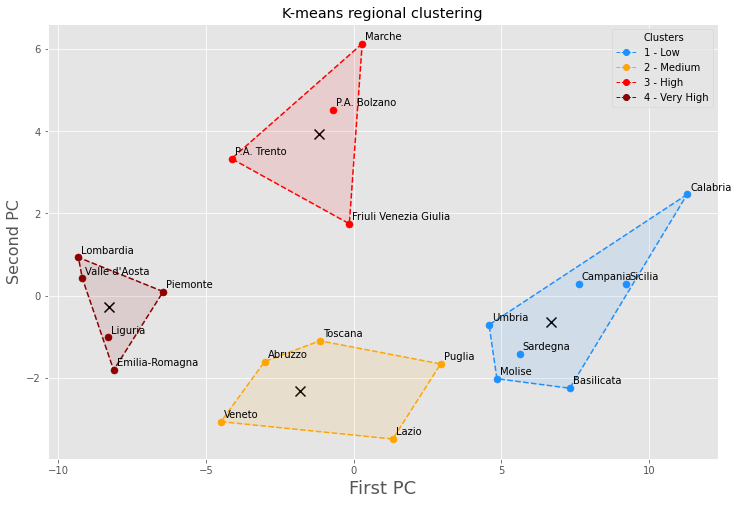

In [815]:
# Visualize regions over the first two components

col_km = ['red', 'orange', 'dodgerblue', 'darkred']
clus_label = ['Low', 'Medium', 'High', 'very high']
X = plot_columns[:,0]

y = km_results.labels_
centroids = KMeans(n_clusters=nc, random_state=123).fit(plot_columns).cluster_centers_
fig, ax = plt.subplots(1, figsize=(12, 8))

for i in range(nc):
    points = plot_columns[y == i]
    ax.scatter(points[:, 0], points[:, 1], s=50, c=col_km[i], label=f'{i+1} - {clus_label[i]}')
    if len(points) > 2:
        hull = ConvexHull(points)
        vert = np.append(hull.vertices, hull.vertices[0])  # close the polygon by appending the first point at the end
        ax.plot(points[vert, 0], points[vert, 1], '--', c=col_km[i])
        ax.fill(points[vert, 0], points[vert, 1], c=col_km[i], alpha=0.1)
    
for index, row in clusters_km.iterrows():
    ax.annotate(row['Regions'], (row['PC_1'] + .1, row['PC_2'] + .1))

ax.scatter(centroids[:, 0], centroids[:, 1], s=100, c='black', label='Centroids', marker='x')

#ax.legend()
custom_lines = [
    Line2D([0], [0], color='#E5E5E5', lw=0), 
    Line2D([0], [0], color='dodgerblue', lw=1, linestyle='--', marker='o'), 
    Line2D([0], [0], color='orange', lw=1, linestyle='--', marker='o'), 
    Line2D([0], [0], color='red', lw=1, linestyle='--', marker='o'),
    Line2D([0], [0], color='darkred', lw=1, linestyle='--', marker='o')
]

ax.legend(custom_lines, ['Clusters', '1 - Low', '2 - Medium', '3 - High', '4 - Very High'])


plt.xlabel('First PC', fontsize=18)
plt.ylabel('Second PC', fontsize=16)

plt.title('K-means regional clustering')
plt.show()

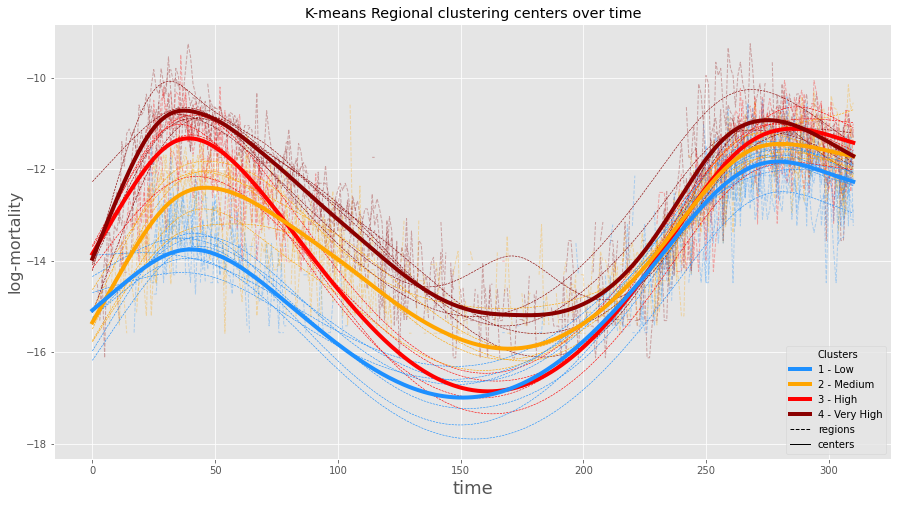

In [816]:
# compute cluster centers

Centers = [np.array(fit_i.rx2('B')).dot(km_results.cluster_centers_[i]) for i in np.arange(nc)]
Centers = pd.DataFrame(np.array(Centers).T)

clist = np.array(np.array(col_km))[clusters_km['Cluster'].values - 1]
#clist = np.where(clist == 'red', 'orange', np.where(clist == 'orange', 'red', clist))

fig, ax = plt.subplots(1, figsize=(15, 8))
ax.set_prop_cycle('color', clist)

ax.plot(t, LMX, linewidth=1, linestyle="--", alpha=.3)
ax.plot(t, LMX_hat, linestyle="--", linewidth=.6, alpha=1)

ax.set_prop_cycle('color', col_km)

ax.plot(Centers, linewidth=4)

plt.xlabel('time', fontsize=18)
plt.ylabel('log-mortality', fontsize=16)

plt.title('K-means Regional clustering centers over time')

custom_lines = [
    Line2D([0], [0], color='#E5E5E5', lw=0), 
    Line2D([0], [0], color='dodgerblue', lw=4), 
    Line2D([0], [0], color='orange', lw=4), 
    Line2D([0], [0], color='red', lw=4),
    Line2D([0], [0], color='darkred', lw=4),
    Line2D([0], [0], color='black', lw=1, linestyle='--'),
    Line2D([0], [0], color='black', lw=1)
]


ax.legend(custom_lines, ['Clusters', '1 - Low', '2 - Medium', '3 - High', '4 - Very High', 'regions', 'centers'])

plt.show()

### Compute confusion matrix on k-means

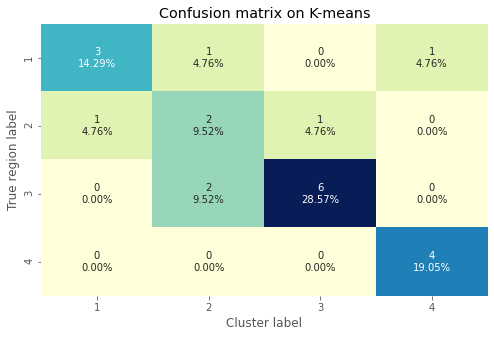

In [818]:
clusters_km['label'] = [4, 4, 4, 1, 1, 1, 1, 4, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3]

cf_matrix = confusion_matrix(clusters_km.label, clusters_km.Cluster)

group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v2}\n{v3}" for v2, v3 in zip(group_counts, group_percentages)]

labels = np.asarray(labels).reshape(4,4)

plt.figure(figsize=(8,5))
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='YlGnBu', cbar=False)
ax.set_xticklabels([1, 2, 3, 4])
ax.set_yticklabels([1, 2, 3, 4])
plt.title("Confusion matrix on K-means")
plt.xlabel("Cluster label") 
plt.ylabel("True region label") 
plt.show()

### Hierarchical clustering
Getting the scores with cophenet misure, the best method is the agerage.

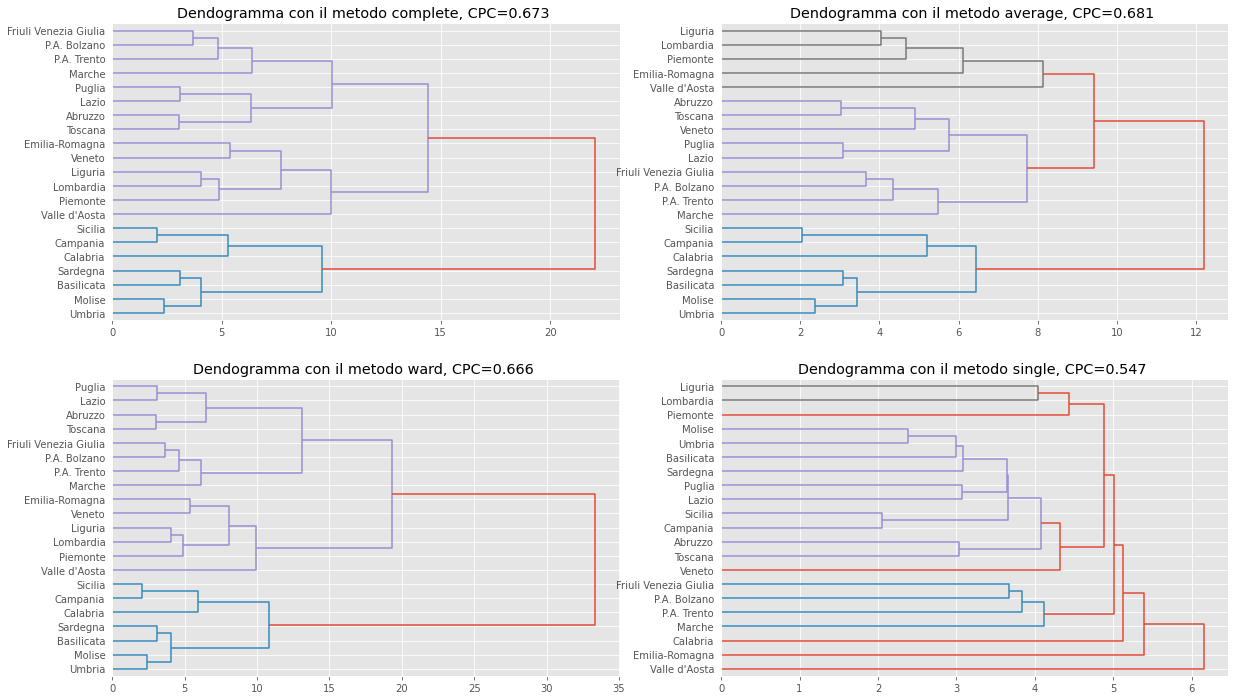

In [819]:
distanceMatrix = pdist(dati, metric='euclidean')
figCLH, axesCLH = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))
methods = set(["ward", "complete", "average", "single"])
methodsUsed = set({})
for i in np.arange(2):
    for method, j in zip(methods - methodsUsed, np.arange(2)):
        hierarchicalClustering = linkage(dati, method=method)
        dendrogram(hierarchicalClustering, ax=axesCLH[i][j], labels=reg, orientation='right')
        cpc, cp = cophenet(hierarchicalClustering, distanceMatrix)
        axesCLH[i][j].set_title("Dendogramma con il metodo {}, CPC={:.3f} ".format(method, cpc))
        methodsUsed.add(method)

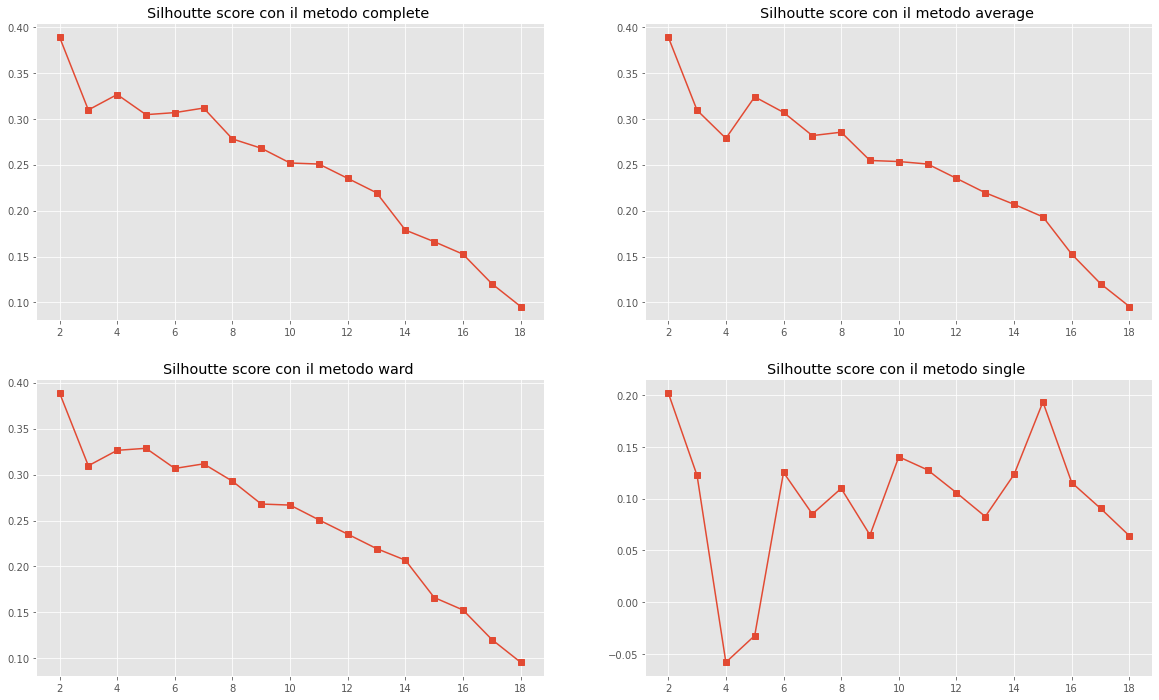

In [821]:
figCLH, axesCLH = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))
silhoutteValutations = []
methods = set(["ward", "complete", "average", "single"])
methodsUsed = set({})
K = np.arange(2, 19)

for i in np.arange(2):
    for method, j in zip(methods - methodsUsed, np.arange(2)):
        for k in K:
            cluster = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage=method).fit(dati)
            silhoutteValutations.append(silhouette_score(dati, cluster.labels_, metric='euclidean'))
        
        axesCLH[i][j].set_title("Silhoutte score con il metodo {} ".format(method))
        axesCLH[i][j].plot(K, silhoutteValutations, marker='s')
        methodsUsed.add(method)
        silhoutteValutations = []

plt.show()

In [822]:
nc = 4
np.random.seed(123)

hc_results = AgglomerativeClustering(n_clusters=nc, affinity='euclidean', linkage='ward').fit(dati)
clusters_hc = pd.DataFrame({'Regions': reg, 'Cluster': hc_results.labels_ + 1})

pca_2 = PCA(n_components=2)
plot_columns = pca_2.fit_transform(dati)

clusters_hc['PC_1'] = plot_columns[:, 0]
clusters_hc['PC_2'] = plot_columns[:, 1]

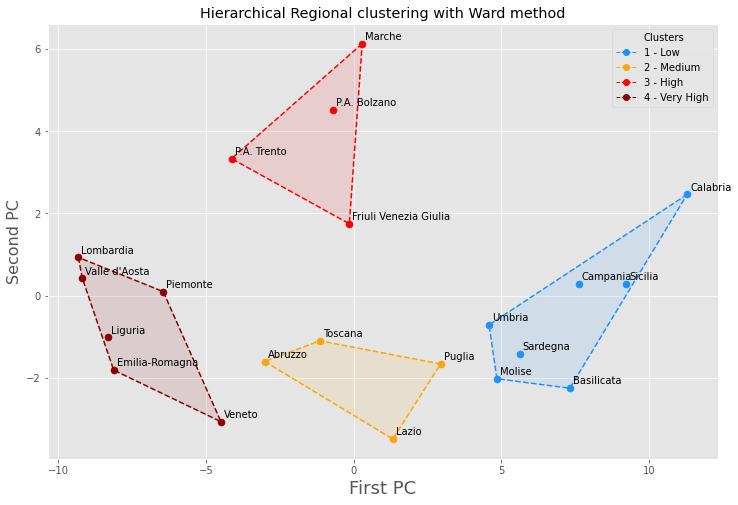

In [823]:
# Visualize regions over the first two components

col_hc = ['dodgerblue', 'orange', 'darkred', 'red']
clus_label = ['Low', 'Medium', 'High', 'Very High']
X = plot_columns[:,0]

y = hc_results.labels_
fig, ax = plt.subplots(1, figsize=(12, 8))

for i in range(nc):
    points = plot_columns[y == i]
    ax.scatter(points[:, 0], points[:, 1], s=50, c=col_hc[i], label=f'{i+1} - {clus_label[i]}')
    if len(points) > 2:
        hull = ConvexHull(points)
        vert = np.append(hull.vertices, hull.vertices[0])  # close the polygon by appending the first point at the end
        ax.plot(points[vert, 0], points[vert, 1], '--', c=col_hc[i])
        ax.fill(points[vert, 0], points[vert, 1], c=col_hc[i], alpha=0.1)
    
for index, row in clusters_hc.iterrows():
    ax.annotate(row['Regions'], (row['PC_1'] + .1, row['PC_2'] + .1))


ax.legend()

#ax.legend()
custom_lines = [
    Line2D([0], [0], color='#E5E5E5', lw=0), 
    Line2D([0], [0], color='dodgerblue', lw=1, linestyle='--', marker='o'), 
    Line2D([0], [0], color='orange', lw=1, linestyle='--', marker='o'), 
    Line2D([0], [0], color='red', lw=1, linestyle='--', marker='o'),
    Line2D([0], [0], color='darkred', lw=1, linestyle='--', marker='o')
]

ax.legend(custom_lines, ['Clusters', '1 - Low', '2 - Medium', '3 - High', '4 - Very High'])


plt.xlabel('First PC', fontsize=18)
plt.ylabel('Second PC', fontsize=16)

plt.title('Hierarchical Regional clustering with Ward method')
plt.show()

### Compute confusion matrix on Hierarchical clustering

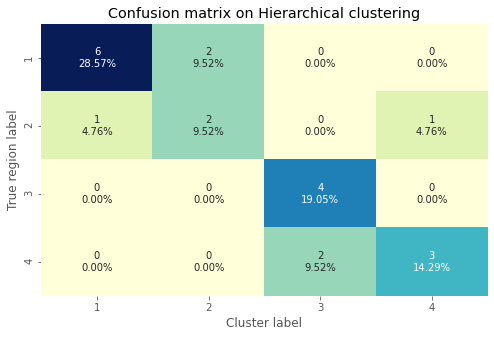

In [824]:
clusters_hc['label'] = [3, 3, 3, 4, 4, 4, 4, 3, 4, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1]

cf_matrix = confusion_matrix(clusters_hc.label, clusters_hc.Cluster)

group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v2}\n{v3}" for v2, v3 in zip(group_counts, group_percentages)]

labels = np.asarray(labels).reshape(4,4)

plt.figure(figsize=(8,5))
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='YlGnBu', cbar=False)
ax.set_xticklabels([1, 2, 3, 4])
ax.set_yticklabels([1, 2, 3, 4])
plt.title("Confusion matrix on Hierarchical clustering")
plt.xlabel("Cluster label") 
plt.ylabel("True region label") 
plt.show()

## Visualize clusters over Italy

Get geomap information

In [825]:
url = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-json/dpc-covid19-ita-regioni.json"
df_regioni = pd.read_json(url)

In [826]:
import urllib.request, json 

with urllib.request.urlopen("https://gist.githubusercontent.com/datajournalism-it/f1abb68e718b54f6a0fe/raw/23636ff76534439b52b87a67e766b11fa7373aa9/regioni-con-trento-bolzano.geojson") as url:
    geojson_italy_provinces = json.loads(url.read().decode())

In [827]:
for item in geojson_italy_provinces["features"]:
    item['regioni'] = item['properties']['Regione']

### Visualize K-means cluters

In [828]:
clusters_km.iat[3, 0] = "Trento"
clusters_km.iat[4, 0] = "Bolzano"
clusters_km.iat[8, 0] = "Emilia Romagna"
clusters_km.iat[18, 2] = clusters_km.iat[18, 2] / 2

clusters_km['PC_1'] = abs(clusters_km['PC_1'])
min_max_scaler = preprocessing.MinMaxScaler()
clusters_km['PC_1'] = min_max_scaler.fit_transform(clusters_km['PC_1'].values.reshape(-1, 1))
clusters_km['PC_1'] = np.where(clusters_km['PC_1'] < .2, .2, clusters_km['PC_1'])

In [829]:
step = cmp.StepColormap(
    col_km,
    vmin=0, vmax=4,
    index=[0, 1, 2, 3, 4], 
    caption=' Colour transparency is proportional to regional value associated to the first PC.'
)

In [830]:
dt = clusters_km.set_index('Regions')[['Cluster', 'PC_1']]

italy_map = folium.Map([43, 12], width=1000,height=1400, tiles='Mapbox Bright', zoom_start=5.5)
folium.GeoJson(
    geojson_italy_provinces,
    style_function=lambda feature: {
        'fillColor': step(dt.loc[feature['regioni']][0]),
        'color': 'black',      
        'weight': 1,           
        'dashArray': '5, 3',
        'fillOpacity': dt.loc[feature['regioni']][1],
    }
).add_to(italy_map)
#step.add_to(italy_map)  #adds colorscale or legend

for r in geojson_italy_provinces['features']:
    region = r['properties']['Regione']
    coord = shape(r['geometry']).centroid
    folium.map.Marker(location=[coord.y + .4, coord.x - .5], icon=DivIcon(
        icon_size=(150, 36),
        icon_anchor=(0, 0),
        html='<div style="font-size: 10pt; color:black">{}</div>'.format(str(region))
    )).add_to(italy_map)
    
    
with open('../resources/leggend_style.htm', 'r') as f:
    template = f.read()

macro = MacroElement()
macro._template = Template(template)

italy_map.get_root().add_child(macro)

italy_map

### Visualize Hierarchical cluters

In [831]:
clusters_hc.iat[3, 0] = "Trento"
clusters_hc.iat[4, 0] = "Bolzano"
clusters_hc.iat[8, 0] = "Emilia Romagna"
clusters_hc.iat[18, 2] = clusters_hc.iat[18, 2] / 2
clusters_hc.iat[9, 2] = .3

clusters_hc['PC_1'] = abs(clusters_hc['PC_1'])
min_max_scaler = preprocessing.MinMaxScaler()
clusters_hc['PC_1'] = min_max_scaler.fit_transform(clusters_hc['PC_1'].values.reshape(-1, 1))
clusters_hc['PC_1'] = np.where(clusters_hc['PC_1'] < .2, .3, clusters_hc['PC_1'])

In [832]:
step = cmp.StepColormap(
    col_hc,
    vmin=0, vmax=4,
    index=[0, 1, 2, 3, 4], 
    caption=' Colour transparency is proportional to regional value associated to the first PC.'
)

In [833]:
dt = clusters_hc.set_index('Regions')[['Cluster', 'PC_1']]

italy_map = folium.Map([43, 12], width=1000,height=1400, tiles='Mapbox Bright', zoom_start=5.5)
folium.GeoJson(
    geojson_italy_provinces,
    style_function=lambda feature: {
        'fillColor': step(dt.loc[feature['regioni']][0]),
        'color': 'black',      
        'weight': 1,           
        'dashArray': '5, 3',
        'fillOpacity': dt.loc[feature['regioni']][1],
    }
).add_to(italy_map)
#step.add_to(italy_map)  #adds colorscale or legend

for r in geojson_italy_provinces['features']:
    region = r['properties']['Regione']
    coord = shape(r['geometry']).centroid
    folium.map.Marker(location=[coord.y + .4, coord.x - .5], icon=DivIcon(
        icon_size=(150, 36),
        icon_anchor=(0, 0),
        html='<div style="font-size: 10pt; color:black">{}</div>'.format(str(region))
    )).add_to(italy_map)
    
    
with open('../resources/leggend_style_hc.htm', 'r') as f:
    template = f.read()

macro = MacroElement()
macro._template = Template(template)

italy_map.get_root().add_child(macro)

italy_map